- template spectrum (median from all frames) interpolated to a finer (x 10) resolution

- sample each individual spectrum at same finer resolution

- cross correlation between the two (y-axis centered on 0)

In [165]:
import numpy as np
from math import log10
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.time import Time
from scipy.signal import correlate
from tqdm import tqdm_notebook

plt.rcParams['font.size'] = 18

In [2]:
WAVELENGTHS = np.load('interp_1d_wavelength.npy', allow_pickle=True)
SPECTRA = np.load('interp_1d_spectra.npy', allow_pickle=True)
TIMES = Time(np.load('mjddates.npy', allow_pickle=True), format='mjd').jd

BOTH = np.where(TIMES<=2458870.762)[0]
TRANSIT_C = np.where( (TIMES>2458870.762) & (TIMES<=2458870.941))[0]
OUT = np.where( TIMES>2458870.941)[0]

In [183]:
template = np.nanmedian(SPECTRA, axis=0)

In [59]:
def grid_wavelength(wavelength, spectra, factor):
    
    interp_waves = np.zeros((wavelength.shape[0], wavelength.shape[1]*factor))
    interp_spect = np.zeros((spectra.shape[0], spectra.shape[1]*factor))
    
    start = wavelength[:,0]
    end = wavelength[:,-1]

    redstart = np.nanmax(start)
    blueend  = np.nanmin(end)

    finer_wavelength = np.logspace(log10(redstart), log10(blueend),
                                   wavelength.shape[1]*factor, base=10.0)
    finer_wavelength[0] = redstart
    
    for i in range(len(wavelength)):
        f = interp1d(wavelength[i], spectra[i])
        interp_spect[i] = f(finer_wavelength)
        interp_waves[i] = finer_wavelength
    return interp_waves, interp_spect

In [ ]:
def fit_maximum(wave, spectra, order, region):

    wave_reg = wave[10][order][region]
    
    plt.plot(wave[10][order], spectra[10][order])
    plt.xlim([wave_reg[0], wave_reg[-1]])
    
    x = np.arange(wave_reg[0], wave_reg[-1], 0.001)
    fit = np.polyfit(wave[10][order][region], 
                     np.nanmedian(spectra[:,order,region], axis=0), deg=2)
    model = np.poly1d(fit)
    model_tip = model(x)
    
    plt.plot(x, model_tip, 'k')
    plt.plot(x[np.argmin(model_tip)], model_tip[np.argmin(model_tip)], 'ro')
    plt.title(x[np.argmin(model_tip)])
    plt.show()
    
    return x[np.argmin(model_tip)]

In [68]:
factor = 20
interp_wave = np.zeros((SPECTRA.shape[0], SPECTRA.shape[1], SPECTRA.shape[2]*factor))
interp_spec = np.zeros((SPECTRA.shape[0], SPECTRA.shape[1], SPECTRA.shape[2]*factor))

temp_interp_wave = np.zeros((SPECTRA.shape[1], SPECTRA.shape[2]*factor))
temp_interp_spec = np.zeros((SPECTRA.shape[1], SPECTRA.shape[2]*factor))

for i, order in enumerate(range(WAVELENGTHS.shape[1])):
    iw, iss = grid_wavelength(WAVELENGTHS[:,order], SPECTRA[:,order], factor)
    interp_wave[:,i] = iw
    interp_spec[:,i] = iss

In [113]:
for i, order in enumerate(range(template.shape[0])):
    finer_wavelength = np.logspace(log10(np.nanmin(WAVELENGTHS[0][order])), 
                                   log10(np.nanmax(WAVELENGTHS[0][order])),
                                   WAVELENGTHS[0].shape[1]*factor, base=10.0)
    finer_wavelength[0] = np.nanmin(WAVELENGTHS[0][order][0])
    f = interp1d(WAVELENGTHS[0][order], template[order])
    
    temp_interp_wave[i] = finer_wavelength
    temp_interp_spec[i] = f(finer_wavelength)

## Perform cross correlation for each order

In [164]:
cross_corr = np.zeros((interp_spec.shape[0], interp_spec.shape[2]))

In [167]:
 for i in tqdm_notebook(range(interp_spec.shape[0])):
    corr = correlate(temp_interp_spec[HALPHA_ORDER] - np.nanmedian(temp_interp_spec[HALPHA_ORDER]), 
                     interp_spec[i][HALPHA_ORDER] - np.nanmedian(interp_spec[i][HALPHA_ORDER]), 
                     mode='same', method='direct')
    cross_corr[i] = corr

In [210]:
HALPHA_ORDER = 11
HALPHA_REGION = np.where( (temp_interp_wave[HALPHA_ORDER] >= 655.6) & 
                          (temp_interp_wave[HALPHA_ORDER] <= 656.7) )[0]

peaks = np.argmax(cross_corr, axis=1)

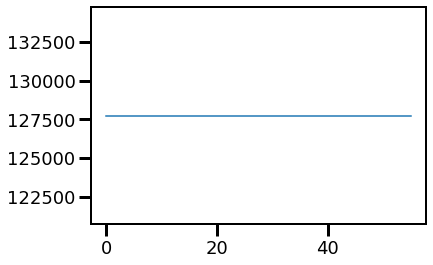

In [212]:
plt.plot(peaks);